# Jupyter Notebook: Custom Attention Optimization

Description:
------------
In this notebook, we will:
1. Load a pre-built language model (LLM).
2. Create a copy of the model architecture but replace its attention mechanism with an implementation of Native Sparse Attention from Deepseek.
3. Implement a process to compare the outputs of both models and compute a KL-divergence loss.
4. Optimize the custom model's parameters by minimizing the KL-divergence between the two models’ distributions.
5. Demonstrate how to evaluate and compare both models on sample data.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install datasets
!pip install native-sparse-attention-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
############## # Code Block 1: Imports & Config ##############
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import math
from native_sparse_attention_pytorch import SparseAttention
import time
import psutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "gpt2"
SEQ_LEN = 128
BATCH_SIZE = 4
NUM_HEADS = 4
COMPRESS_RATIO = 0.25
WINDOW_SIZE = 64
NUM_EPOCHS = 50

# Native sparse attention configuration
SPARSE_CONFIG = {
    "dim": None,  # Will be set in the model
    "dim_head": 64,  # Dimension per head
    "heads": NUM_HEADS,
    "sliding_window_size": 2,  # Local attention window
    "compress_block_size": 4,  # Size of blocks to compress
    "selection_block_size": 4,  # Size of blocks to select from
    "num_selected_blocks": 2,  # Number of blocks to select
}

In [4]:
############## # Code Block 2: Sparse Attention Components ##############
class CompressedGlobalAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, compress_ratio):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.compress_ratio = compress_ratio

        self.Wq = nn.Linear(embed_dim, embed_dim)
        self.Wk = nn.Linear(embed_dim, embed_dim)
        self.Wv = nn.Linear(embed_dim, embed_dim)
        self.compression = nn.Linear(embed_dim, 1)
        self.expansion = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, attention_mask=None):
        B, T, D = x.shape
        keep_num = max(1, int(T * self.compress_ratio))

        # Token compression
        importance = self.compression(x).squeeze(-1)
        _, keep_idx = torch.topk(importance, k=keep_num, dim=-1)
        x_compressed = torch.gather(x, 1, keep_idx.unsqueeze(-1).expand(-1, -1, D))

        # Projections
        Q = self.Wq(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = (
            self.Wk(x_compressed)
            .view(B, keep_num, self.num_heads, self.head_dim)
            .permute(0, 2, 1, 3)
        )
        V = (
            self.Wv(x_compressed)
            .view(B, keep_num, self.num_heads, self.head_dim)
            .permute(0, 2, 1, 3)
        )

        # Attention
        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim)

        # Masking
        if attention_mask is not None:
            compressed_mask = torch.gather(attention_mask, 1, keep_idx)
            attn_scores = attn_scores.masked_fill(
                compressed_mask.unsqueeze(1).unsqueeze(2) == 0, -1e10
            )

        attn_weights = F.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        output = output.permute(0, 2, 1, 3).contiguous().view(B, T, D)

        output = self.expansion(output)  # Ensure output has correct embedding dimension
        output = output[:, : x.size(1), :]

        return output


class LocalWindowAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, window_size):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.window_size = window_size

        self.Wq = nn.Linear(embed_dim, embed_dim)
        self.Wk = nn.Linear(embed_dim, embed_dim)
        self.Wv = nn.Linear(embed_dim, embed_dim)

    def create_window_mask(self, seq_len, device):
        mask = torch.zeros(seq_len, seq_len, device=device)
        for i in range(seq_len):
            start = max(0, i - self.window_size // 2)
            end = min(seq_len, i + self.window_size // 2 + 1)
            mask[i, start:end] = 1
        return mask.unsqueeze(0).unsqueeze(1)

    def forward(self, x, attention_mask=None):
        B, T, D = x.shape
        window_mask = self.create_window_mask(T, x.device)

        Q = self.Wq(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.Wk(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.Wv(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim)
        attn_scores = attn_scores.masked_fill(window_mask == 0, -1e10)

        if attention_mask is not None:
            attn_scores = attn_scores.masked_fill(
                attention_mask.unsqueeze(1).unsqueeze(2) == 0, -1e10
            )

        attn_weights = F.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        return output.permute(0, 2, 1, 3).contiguous().view(B, T, D)


class HierarchicalSparseAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, window_size, compress_ratio):
        super().__init__()
        self.num_heads = num_heads  # 🔹 Store num_heads
        self.local_attn = LocalWindowAttention(embed_dim, num_heads, window_size)
        self.global_attn = CompressedGlobalAttention(
            embed_dim, num_heads, compress_ratio
        )
        self.gate = nn.Sequential(
            nn.Linear(
                embed_dim, num_heads * 2
            ),  # Ensure output is [batch, seq_len, num_heads * 2]
            nn.Softmax(dim=-1),
        )
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, attention_mask=None):
        # Get outputs from local and global attention modules.
        local_out = self.local_attn(x, attention_mask)  # Expected shape: (B, T, D)
        global_out = self.global_attn(x, attention_mask)  # Expected shape: (B, T, D)

        B, T, D = x.size()
        head_dim = D // self.num_heads  # Ensure D is divisible by num_heads

        # Compute gating weights.
        # self.gate should output a tensor of shape (B, T, num_heads*2)
        gate_out = self.gate(x)  # Shape: (B, T, num_heads*2)
        # Reshape to (B, T, num_heads, 2) where last dim holds [local_gate, global_gate]
        gates = gate_out.view(B, T, self.num_heads, 2)
        # Unbind the last dimension into two tensors
        local_gate = gates[..., 0]  # Shape: (B, T, num_heads)
        global_gate = gates[..., 1]  # Shape: (B, T, num_heads)

        # Reshape attention outputs to split heads: (B, T, num_heads, head_dim)
        local_out_heads = local_out.view(B, T, self.num_heads, head_dim)
        global_out_heads = global_out.view(B, T, self.num_heads, head_dim)

        # Ensure the gate tensors have an extra dimension for broadcasting: (B, T, num_heads, 1)
        local_gate = local_gate.unsqueeze(-1)
        global_gate = global_gate.unsqueeze(-1)

        # Element-wise multiply each head output by its corresponding gate weight
        combined = local_out_heads * local_gate + global_out_heads * global_gate
        # Reshape back to (B, T, D)
        combined = combined.view(B, T, D)
        return self.out_proj(combined)

In [5]:
############## # Code Block 3: Custom GPT-2 Model ##############
class SparseGPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.hidden_size)
        self.wpe = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.drop = nn.Dropout(config.embd_pdrop)

        # Sparse attention
        sparse_config = SPARSE_CONFIG.copy()
        sparse_config["dim"] = config.hidden_size
        sparse_config["compress_block_sliding_stride"] = 2
        self.sparse_attn = SparseAttention(**sparse_config)

        self.h = nn.ModuleList([
            nn.ModuleDict({
                "attn": self.sparse_attn,
                "ln_1": nn.LayerNorm(config.hidden_size),
                "mlp": nn.Sequential(
                    nn.Linear(config.hidden_size, 4 * config.hidden_size),
                    nn.GELU(),
                    nn.Linear(4 * config.hidden_size, config.hidden_size),
                ),
                "ln_2": nn.LayerNorm(config.hidden_size),
            })
            for _ in range(config.num_hidden_layers)
        ])
        self.ln_f = nn.LayerNorm(config.hidden_size)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size)

    def forward(self, input_ids, attention_mask=None, labels=None, target_logits=None):
        B, T = input_ids.size()
        pos_ids = torch.arange(T, device=input_ids.device).unsqueeze(0)

        x = self.drop(self.wte(input_ids) + self.wpe(pos_ids))
        attn_out = torch.zeros_like(x)

        for block in self.h:
            normed_x = block["ln_1"](x)
            attention_result = block["attn"](normed_x)

            if attention_result is not None:
                attn_out = attention_result

            if attention_mask is not None:
                attn_out = attn_out * attention_mask.unsqueeze(-1)

            x = x + attn_out
            x = x + block["mlp"](block["ln_2"](x))

        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        ce_loss = None
        kl_loss = None

        if labels is not None:
            # Next-token prediction: shift left
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            ce_loss = nn.CrossEntropyLoss()(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        if target_logits is not None:
            # KL Divergence between current logits and target (e.g., teacher model)
            shift_logits = logits[:, :-1, :].contiguous()
            shift_target_logits = target_logits[:, 1:, :].contiguous()

            kl_loss_fn = nn.KLDivLoss(reduction="sum")
            kl_loss = kl_loss_fn(
                F.log_softmax(shift_logits, dim=-1),
                F.softmax(shift_target_logits, dim=-1)
            )

        # Combine losses if both are present
        if ce_loss is not None and kl_loss is not None:
            loss = ce_loss + kl_loss
        elif ce_loss is not None:
            loss = ce_loss
        elif kl_loss is not None:
            loss = kl_loss


        if labels is not None and target_logits is not None:
            return {"loss": loss, "logits": logits, "ce_loss": ce_loss, "kl_loss": kl_loss}
        else:
            return logits


In [6]:
############## # Code Block 4: Training Setup ##############
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

# Reference model
ref_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
ref_model.eval()

# Custom model with native sparse attention
cust_config = GPT2Config.from_pretrained(MODEL_NAME)
cust_model = SparseGPT2(cust_config).to(DEVICE)

# Initialize with pretrained weights
pretrained_state_dict = ref_model.state_dict()
cust_model.load_state_dict(pretrained_state_dict, strict=False)

# Use a lower learning rate for fine-tuning
optimizer = torch.optim.AdamW(cust_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
############## # Code Block 5: Training Loop ##############
class UsageTracker:
    def __init__(self):
        self.start_time = None
        self.start_cpu_time = None
        self.train_stats = {
            "epoch": [], "step": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }
        self.infer_stats = {
            "max_token_length": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }

    def start_tracking(self):
        self.start_time = time.time()
        self.start_cpu_time = time.process_time()

    def stop_tracking(self, is_training, epoch=None, step=None, max_token_length=None):
        if self.start_time is None or self.start_cpu_time is None:
            raise ValueError("Tracking not started. Call start_tracking() first.")

        end_time = time.time()
        end_cpu_time = time.process_time()

        proc = psutil.Process(os.getpid())
        cpu_mem = proc.memory_info().rss / (1024**2)
        if torch.cuda.is_available():
            gpu_alloc    = torch.cuda.memory_allocated(DEVICE) / (1024**2)
            gpu_reserved = torch.cuda.memory_reserved(DEVICE) / (1024**2)
        else:
            gpu_alloc = gpu_reserved = 0.0

        obj = self.train_stats if is_training else self.infer_stats
        obj["wall_time_s"].append(end_time - self.start_time)
        obj["cpu_time_s"].append(end_cpu_time - self.start_cpu_time)
        obj["cpu_mem_mb"].append(cpu_mem)
        obj["gpu_alloc_mb"].append(gpu_alloc)
        obj["gpu_reserved_mb"].append(gpu_reserved)
        if is_training:
            obj["epoch"].append(epoch + 1)
            obj["step"].append(step + 1)
        else:
            obj["max_token_length"].append(max_token_length)

        self.start_time = None
        self.start_cpu_time = None

    def plot(self):
        df_train = pd.DataFrame(self.train_stats)
        df_inf   = pd.DataFrame(self.infer_stats)

        # --- Training plots (line plots vs. step) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.plot(df_train["step"], df_train[metric])
            plt.xlabel("Training Step")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} During Training")
            plt.show()

        prompt_lengths = self.infer_stats["max_token_length"]

        # --- Inference plots (bar plots vs. token length) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.scatter(prompt_lengths, self.infer_stats[metric])
            plt.xlabel("Prompt Token Length")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} vs. Prompt Length")
            plt.show()

def kl_divergence_loss(logits_custom, logits_ref, mask, temperature):
    # 1) soften both distributions by T
    logp_c = F.log_softmax(logits_custom / temperature, dim=-1)
    p_r   = F.softmax(   logits_ref.detach() / temperature, dim=-1)

    # 2) per‑token KL
    kl = (p_r * (p_r.log() - logp_c)).sum(-1)  # (B, L)

    # 3) average over real tokens and re‑scale by T^2
    return (kl * mask).sum() / mask.sum() * (temperature * temperature)

def train_step(batch, epoch, step):
    tracker.start_tracking()

    inputs = batch.to(DEVICE)
    attention_mask = (inputs != tokenizer.pad_token_id).float()
    labels = inputs  # Next-token prediction: input shifted by 1 internally in model

    with torch.no_grad():
        ref_outputs = ref_model(inputs, attention_mask=attention_mask)
        ref_logits = ref_outputs[0] if isinstance(ref_outputs, tuple) else ref_outputs.logits

    # Pass labels and ref logits to custom model
    cust_outputs = cust_model(
        input_ids=inputs,
        attention_mask=attention_mask,
        labels=labels,
        target_logits=ref_logits
    )

    loss = cust_outputs["loss"]

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(cust_model.parameters(), 1.0)
    optimizer.step()

    tracker.stop_tracking(is_training=True, epoch=epoch, step=step)

    return loss.item()


def train_epoch(loader, epoch):
    cust_model.train()
    total_loss = 0
    loss_vals = []
    for i, batch in tqdm(enumerate(loader), desc="Training"):
        loss = train_step(batch, epoch, i)
        total_loss += loss
        loss_vals.append(loss)
    return total_loss / len(loader), loss_vals

In [8]:
############## # Code Block 6: Generation & Evaluation ##############
def generate(model, tokenizer, prompt, max_length=50, temperature=0.7, top_k=50, device="cuda" if torch.cuda.is_available() else "cpu"):
    input_ids = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=False).to(device)
    input_ids = input_ids[:1]  # Ensure we only have one batch dimension

    model.to(device)
    model.eval()

    for _ in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs

            # Get logits for the last token
            if logits.dim() == 3:  # Standard shape [batch, seq, vocab]
                next_token_logits = logits[:, -1, :] / temperature
            elif logits.dim() == 2:  # If somehow we got [batch*seq, vocab]
                # We only care about the last token's logits
                next_token_logits = logits[-1:, :] / temperature
            else:
                raise ValueError(f"Unexpected logits shape: {logits.shape}")

            # Apply top-k filtering
            top_k_logits, top_k_indices = torch.topk(next_token_logits, k=top_k, dim=-1)

            # Convert to probabilities
            probs = F.softmax(top_k_logits, dim=-1)

            # Sample next token index from top-k logits
            next_token_idx = torch.multinomial(probs, num_samples=1)
            next_token = top_k_indices.gather(1, next_token_idx)

            # Ensure next_token has shape [1, 1]
            next_token = next_token[-1:, :]  # Take only the last row if needed

            # Concatenate to input_ids
            input_ids = torch.cat([input_ids, next_token], dim=-1)

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

In [9]:
############## # Code Block 7: Dataset Preparation ##############
from datasets import load_dataset


class WikiDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len):
        self.samples = []
        for text in texts:
            # Tokenize each text separately, without adding special tokens
            token_ids = tokenizer.encode(text, add_special_tokens=False)
            # Split token_ids into chunks of length seq_len
            for i in range(0, len(token_ids), seq_len):
                chunk = token_ids[i : i + seq_len]
                # Only add full chunks to avoid very short sequences
                if len(chunk) == seq_len:
                    self.samples.append(torch.tensor(chunk))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


# Load WikiText data
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train[:100%]")
texts = dataset["text"]
wiki_dataset = WikiDataset(texts, tokenizer, SEQ_LEN)

# Create a DataLoader for training
train_loader = DataLoader(wiki_dataset, batch_size=BATCH_SIZE, shuffle=True)

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [10]:
############## # Code Block 8: Training Execution ##############
tracker = UsageTracker()

CHECKPOINT_DIR = '/content/drive/MyDrive/attention_optimization/model_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

cust_model.train()

avg_loss_training = []

for epoch in range(0, NUM_EPOCHS):

    avg_loss, loss_vals = train_epoch(train_loader, epoch)
    scheduler.step()

    avg_loss_training.append(avg_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Average Loss: {avg_loss:.4f}")

    # Generate sample text after each epoch
    if (epoch + 1) % 2 == 0:  # Generate every 2 epochs
        print("\nGenerating sample text:")
        prompt = "Artificial intelligence"
        print("Reference:", generate(ref_model, tokenizer, prompt, temperature=0.7, top_k=50))
        print("Custom:", generate(cust_model, tokenizer, prompt, temperature=0.7, top_k=50))
        print("\n")

    # checkpoint model vars
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1, # next epoch to start from
            'model_state_dict': cust_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_vals': loss_vals,
        }
        torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'ckpt_epoch_{epoch+1}.pth'))
        print(f"Saved checkpoint for epoch {epoch+1}")

# Final generation comparison
prompt = "Artificial intelligence"
print("\nFinal generation comparison:")
print("Reference:", generate(ref_model, tokenizer, prompt, temperature=0.7, top_k=50))
print("Custom:", generate(cust_model, tokenizer, prompt, temperature=0.7, top_k=50))

checkpoint_tracker = {
    'tracker': tracker
}

torch.save(checkpoint_tracker, os.path.join(CHECKPOINT_DIR, f'ckpt_epoch_tracker.pth'))
print(f"Saved checkpoint tracker")


Training: 2571it [09:05,  4.72it/s]


Epoch 1/50 - Average Loss: 1181.6430


Training: 2571it [09:05,  4.71it/s]


Epoch 2/50 - Average Loss: 797.6531

Generating sample text:
Reference: Artificial intelligence is only one of the many ways in which scientists and engineers have tapped into the power of the Internet. The most obvious example is the Internet. The Internet has changed the way we think about science and technology. It has transformed our daily lives. We
Custom: Artificial intelligence and " "
 is that, and a,,, and and 13, , 20, 000 people million.. million million viewers viewers were about the best $ $, $ million 3 viewers million viewers viewers viewers actors that " is the's a




Training: 2571it [09:02,  4.74it/s]


Epoch 3/50 - Average Loss: 657.2742


Training: 2571it [09:04,  4.72it/s]


Epoch 4/50 - Average Loss: 569.9041

Generating sample text:
Reference: Artificial intelligence is an area that has been hotly debated. For example, the first-person perspective of artificial intelligence (AI) is a huge topic, but this is one area that has been tackled in the future.

In the meantime, there are some
Custom: Artificial intelligenceactions analysis is not a limited long scale data process analysis of data analysis data analysis and of and,,,,, , , the , of , and ., and without the exception same as as a a graph whole on the edge edge vector for




Training: 2571it [09:05,  4.72it/s]


Epoch 5/50 - Average Loss: 508.2548


Training: 2571it [09:03,  4.73it/s]


Epoch 6/50 - Average Loss: 461.1875

Generating sample text:
Reference: Artificial intelligence can make the most of these capabilities.

There are many ways to learn new skills without having to spend many years at the same university. But there are also many ways to learn more quickly, and you can learn by doing.

In
Custom: Artificial intelligence an and it anoryory,,5 p 0, , 0 @/ 8 @@ 4 = 1 , 0 @@. 5 @2 @@ 7 @@, 5 @@ 10) or 2 a dose 1 @@ @@




Training: 2571it [09:03,  4.73it/s]


Epoch 7/50 - Average Loss: 422.2413


Training: 2571it [09:05,  4.71it/s]


Epoch 8/50 - Average Loss: 389.7355

Generating sample text:
Reference: Artificial intelligence is one of the most powerful technologies in the world. It is also one of the most complex, and potentially disruptive, technologies in history.

This article will introduce you to the technical and the technological aspects of artificial intelligence (AI). This section
Custom: Artificial intelligence the human cells..
 The, and many these of human thegivingitive,, and,, , , respectively adults...,..., . red
 blood cells in animals cells cells, 600 and the cells cells are the parasite not




Training: 2571it [09:04,  4.73it/s]


Epoch 9/50 - Average Loss: 361.4333


Training: 2571it [09:05,  4.71it/s]


Epoch 10/50 - Average Loss: 336.9042

Generating sample text:
Reference: Artificial intelligence and artificial intelligence (AI) are not mutually exclusive, but it is possible that more and more people will be able to understand the difference between them. One of the biggest obstacles to AI is the fact that human beings are generally not able to understand machine
Custom: Artificial intelligenceк component can energy gas to and provide a aesthetic receptor that can be used for testing the required the immune and response the of-/ to the brain receptor (L )L nor nor at the cyt cost the best active role. in this case


Saved checkpoint for epoch 10


Training: 2571it [09:04,  4.72it/s]


Epoch 11/50 - Average Loss: 315.2399


Training: 2571it [09:03,  4.73it/s]


Epoch 12/50 - Average Loss: 295.8648

Generating sample text:
Reference: Artificial intelligence, or AI, is a technology that can imagine, predict, and interact with any object and any information it might present to it.

The human brain is also capable of perceiving every detail of all the information in a human's body.
Custom: Artificial intelligence by-df,,,,,, & >, @ @, 000 , 4 @=, 000 @ @, 2, 000 @, 500 @ 1000 @, , 8 @ @ 000 @000 @@, 000 @ 000 @




Training: 2571it [09:04,  4.72it/s]


Epoch 13/50 - Average Loss: 278.3073


Training: 2571it [09:06,  4.70it/s]


Epoch 14/50 - Average Loss: 262.6815

Generating sample text:
Reference: Artificial intelligence is, in many ways, a fundamental component of the real world. It is a crucial part of human life, as we become more mobile. Many of us have been able to do that, and a lot of us are starting to do that.
Custom: Artificial intelligence is a complex term for the,,, or to a,000, 000 of @ 0, 600..

 of-, 000 @ , 2, 5, 2, @@, 5000, 1000 @@, 000 ) ,





Training: 2571it [09:05,  4.71it/s]


Epoch 15/50 - Average Loss: 248.4587


Training: 2571it [09:03,  4.73it/s]


Epoch 16/50 - Average Loss: 235.8960

Generating sample text:
Reference: Artificial intelligence or AI is a field that has been around since the 90s. But now, the fields are on a collision course. The idea is that we will have to address the following problems:

1. What is the value of the information needed
Custom: Artificial intelligence of psychology is not relevant to the development that is a major change in ways the, and the the and the and the development of capital development in,, , to to the the power, and the state.. and as, 000 in and in




Training: 2571it [09:04,  4.72it/s]


Epoch 17/50 - Average Loss: 224.1420


Training: 2571it [09:03,  4.73it/s]


Epoch 18/50 - Average Loss: 213.2971

Generating sample text:
Reference: Artificial intelligence is a new field not only to be explored at the Federal level, but also at the State level. It is possible to develop a neural network that can understand an individual's personality and behavior, but it cannot learn or understand the behavior of other people
Custom: Artificial intelligence is also highlighted in, and beyond the link,,+ of individuals to another one another another another another,,,,@ % %. %. to the one the most-, or even, or possibly other factors.. to obtain a




Training: 2571it [09:05,  4.71it/s]


Epoch 19/50 - Average Loss: 203.4963


Training: 2571it [09:03,  4.73it/s]


Epoch 20/50 - Average Loss: 194.3288

Generating sample text:
Reference: Artificial intelligence could help to solve problems such as energy and food scarcity, the authors write.

"It could also help to predict the future development of food and energy resources and also predict changes in climate and weather," they write.

"The present
Custom: Artificial intelligence,, , @ 1, and 2, 2 , and -
 ( 1 , 4 @ 1 , 3 , , ( ( , no , or in the system of multiplication of A of B ( ) , etc , , etc , and to ,


Saved checkpoint for epoch 20


Training: 2571it [09:05,  4.72it/s]


Epoch 21/50 - Average Loss: 185.6680


Training: 2571it [09:05,  4.71it/s]


Epoch 22/50 - Average Loss: 177.6999

Generating sample text:
Reference: Artificial intelligence and the future of computing are both still in their infancy. We haven't seen any of this yet, but it's clear that we're just getting started, and we've just begun the process of seeing what happens when we do it.


Custom: Artificial intelligence ( ), , and other sources.

 J,, and . 914 ( 2.3 , ) . . ( D 2 2 1 3/) ( the (3R ) . ( . . it also contains a ( : ) ,




Training: 2571it [09:07,  4.70it/s]


Epoch 23/50 - Average Loss: 170.2295


Training: 2571it [09:04,  4.72it/s]


Epoch 24/50 - Average Loss: 163.0864

Generating sample text:
Reference: Artificial intelligence, the kind that's made the world safe for real criminals, is rapidly becoming a real threat to our security, and it's taking a toll on our ability to work with others to improve things.

The most prominent example of this is the
Custom: Artificial intelligence and neuroscience is available on public schools, and by or through means through the standard.
 ( http ) of a regular session or as a check- program .: is an example that the course has to influence on the and must be expected. an




Training: 2571it [09:04,  4.72it/s]


Epoch 25/50 - Average Loss: 156.4458


Training: 2571it [09:06,  4.70it/s]


Epoch 26/50 - Average Loss: 150.1618

Generating sample text:
Reference: Artificial intelligence (AI) is already capable of a huge variety of tasks. So there's no reason to believe AI will be able to do all of them.

But given the technological advances and the need to do intelligent AI and artificial intelligence all over the
Custom: Artificial intelligence........................S.........................




Training: 2571it [09:04,  4.72it/s]


Epoch 27/50 - Average Loss: 144.2107


Training: 2571it [09:05,  4.72it/s]


Epoch 28/50 - Average Loss: 138.5152

Generating sample text:
Reference: Artificial intelligence and the social sciences have long been at the forefront of the technology that could revolutionise the way we live. In the next decade, as computer programming becomes more and more popular, the future for AI will be increasingly complex and unpredictable.

That
Custom: Artificial intelligence in, or more than the rate of patients in-,, 0.
 3, 900 / 3.d+.g & Company ( ) of 933- 10-, 1, 100000 km2 ) of non----,




Training: 2571it [09:05,  4.71it/s]


Epoch 29/50 - Average Loss: 133.3041


Training: 2571it [09:05,  4.71it/s]


Epoch 30/50 - Average Loss: 128.2573

Generating sample text:
Reference: Artificial intelligence, a system that looks like a computer from a distance, can perform tasks more quickly and efficiently than humans.

The research, led by Stanford professor of mechanical and electrical engineering Jonathan S. Watson, is published in the journal Nature Communications.

Custom: Artificial intelligence...... . . . .ing the class of the state by means that of the "pro " , if a " is required) would be considered a right of the " " or "a " " are considered more than "


Saved checkpoint for epoch 30


Training: 2571it [09:04,  4.72it/s]


Epoch 31/50 - Average Loss: 123.4834


Training: 2571it [09:04,  4.72it/s]


Epoch 32/50 - Average Loss: 119.0034

Generating sample text:
Reference: Artificial intelligence is developing to improve health, which is good news for many who have experienced success with such a system.

But the new research, released Thursday, suggests that AI could also improve food quality by creating more nutritious food.

For example,
Custom: Artificial intelligence was developed in the movement and the use of certain information was designed to improve the efficiency of the neural pathway and the brain, and the and the end product, or through and during the end of day. In vitro 4-6, and after it




Training: 2571it [09:04,  4.72it/s]


Epoch 33/50 - Average Loss: 114.8500


Training: 2571it [09:05,  4.71it/s]


Epoch 34/50 - Average Loss: 110.8686

Generating sample text:
Reference: Artificial intelligence is the next step, where more and more people are using artificial intelligence to improve their lives. The next step for AI is to become what people call "autonomous" or "programmable." It is not just the internet, but all of the
Custom: Artificial intelligence for the program of a system--,,,, 1,, 000 000 or @@.
 Theoret of the number of three dimensions per unit of this group. . 1........
 . . .




Training: 2571it [09:06,  4.71it/s]


Epoch 35/50 - Average Loss: 107.2440


Training: 2571it [09:04,  4.72it/s]


Epoch 36/50 - Average Loss: 103.8548

Generating sample text:
Reference: Artificial intelligence is the next big hurdle to make the world a better place.

Advertisement

The AI has long been touted as the future of computing, but many researchers and researchers still believe that it's not yet ready. Even if it does reach a
Custom: Artificial intelligence or intelligence is a learning..

: and a problem that is at the same level (1, 1.. 1....0.000,1, 8 , c..@ . . . . )
 and .




Training: 2571it [09:06,  4.70it/s]


Epoch 37/50 - Average Loss: 100.7519


Training: 2571it [09:04,  4.72it/s]


Epoch 38/50 - Average Loss: 97.9600

Generating sample text:
Reference: Artificial intelligence is an area of intense interest in the field of artificial intelligence, and it has been the focus of research for several years now. The world is now beginning to accept advances in artificial intelligence, and the field is rapidly expanding.

The world is
Custom: Artificial intelligence to be controlled,,,,,, :0, 0, 1, 787, 4 @, 839, 1,, 3, 8 @ 1, 902,, 9 @ 000919 , 5006 @ 607,




Training: 2571it [09:05,  4.71it/s]


Epoch 39/50 - Average Loss: 95.4334


Training: 2571it [09:04,  4.72it/s]


Epoch 40/50 - Average Loss: 93.2014

Generating sample text:
Reference: Artificial intelligence, which can learn more about one person's behavior and react to it in ways that are predictable, has been used in the past to assess a person's behavior, but has never been able to develop a true understanding of a person's personality.

Custom: Artificial intelligence has been used to examine and test--------- and @@ @@,-@ @ @@..@. .@.@@ -@ @@ @@ @@ @@ @@ .


Saved checkpoint for epoch 40


Training: 2571it [09:06,  4.70it/s]


Epoch 41/50 - Average Loss: 91.2604


Training: 2571it [09:04,  4.72it/s]


Epoch 42/50 - Average Loss: 89.5488

Generating sample text:
Reference: Artificial intelligence has been an ongoing topic of discussion for some time now, with a number of companies including Google, Facebook and Microsoft all promoting the technology. The question then, with an increasing amount of interest, is how will this change the way we interact with the
Custom: Artificial intelligence or other types are also found in conjunction with other cell- and biote..g....m.cob.0....d..gggggggggg, or as " or




Training: 2571it [09:04,  4.72it/s]


Epoch 43/50 - Average Loss: 88.1155


Training: 2571it [09:06,  4.71it/s]


Epoch 44/50 - Average Loss: 86.9223

Generating sample text:
Reference: Artificial intelligence is more like a field of science than a discipline. It's a research field that uses scientific methodologies and techniques that are useful, but often do not lead to meaningful, satisfying results.

This is a question that has been asked by philosophers
Custom: Artificial intelligence for the program is not yet is not known or is available on a class and can be measured, and the code for the order.
 More important items are:D,, and from the original list included all items. The new system is still




Training: 2571it [09:04,  4.72it/s]


Epoch 45/50 - Average Loss: 85.9458


Training: 2571it [09:06,  4.70it/s]


Epoch 46/50 - Average Loss: 85.1843

Generating sample text:
Reference: Artificial intelligence is now possible, but it will take some time. And then there's the subject of artificial intelligence, which is not only smart but intelligent enough to know the world.

What I'm saying in this article is that we can't be smart
Custom: Artificial intelligence that is anaer autom.. Theoretital effect that increase the capacity of the end of the body, and therefore can be applied to a solution and the end of replacement induction. For the treatment of the following surgery is not guaranteed, by the




Training: 2571it [09:05,  4.71it/s]


Epoch 47/50 - Average Loss: 84.5858


Training: 2571it [09:06,  4.71it/s]


Epoch 48/50 - Average Loss: 84.1718

Generating sample text:
Reference: Artificial intelligence (AI) is the art of looking at the world in terms of a hierarchy, and it's easy to see how this will influence the way we think about the world. That's why a lot of the stuff that AI is doing is so interesting
Custom: Artificial intelligence in the Medical Center (5, 2011 ) , 28 , ( ). ) , 2002 , 2005 , 22 21stst................@: ). ) , volit ( ) ,




Training: 2571it [09:05,  4.71it/s]


Epoch 49/50 - Average Loss: 83.9149


Training: 2571it [09:03,  4.73it/s]


Epoch 50/50 - Average Loss: 83.7562

Generating sample text:
Reference: Artificial intelligence is not only a potential threat to human health, it's also a potential means of creating a new paradigm for the way we live our lives. In the past, we've looked at it as a dangerous, self-defeating, and un-
Custom: Artificial intelligence, and,2, @001, @ , ILL the original paper.. . A. . . . . code..... -@.T, 0.@ ) and . .) ( ) , and so . all relevant


Saved checkpoint for epoch 50

Final generation comparison:
Reference: Artificial intelligence is not just about computing things. It's about the kinds of things people can do with their brains. And yet, these are only a few of the things that are used to solve problems, like the problem of how to solve a problem where there
Custom: Artificial intelligence from the group of scientists have anthe and their own,,,,, and even more than 90% of possible time time. We have seen in the use of aeroin ( ) of all the present and present for human beings

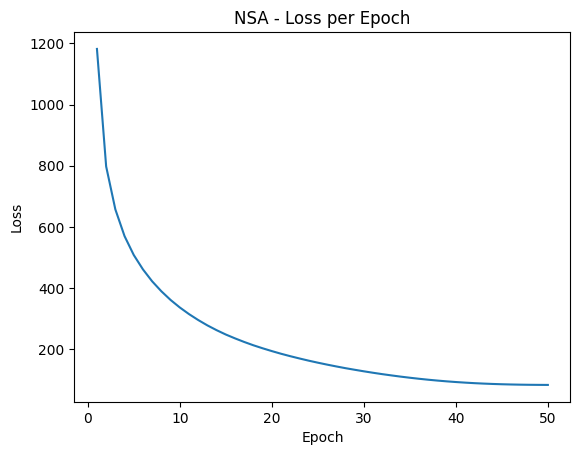

In [11]:
plt.plot(range(1, NUM_EPOCHS + 1), avg_loss_training)
plt.title('NSA - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

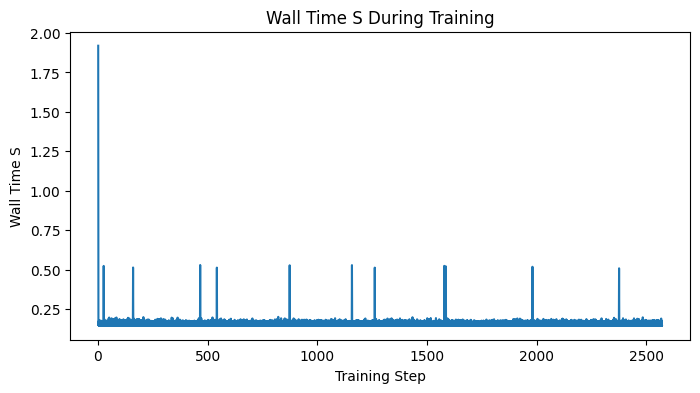

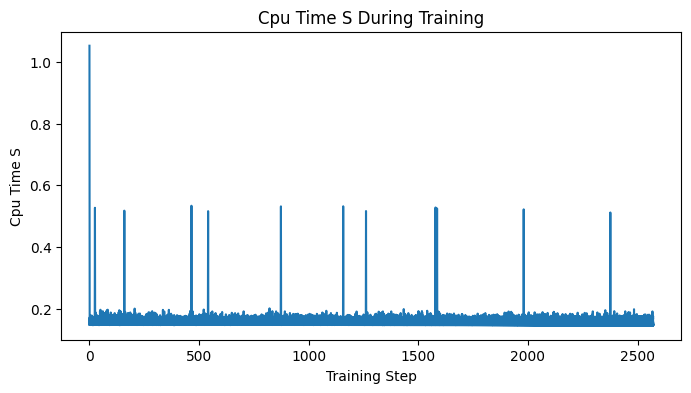

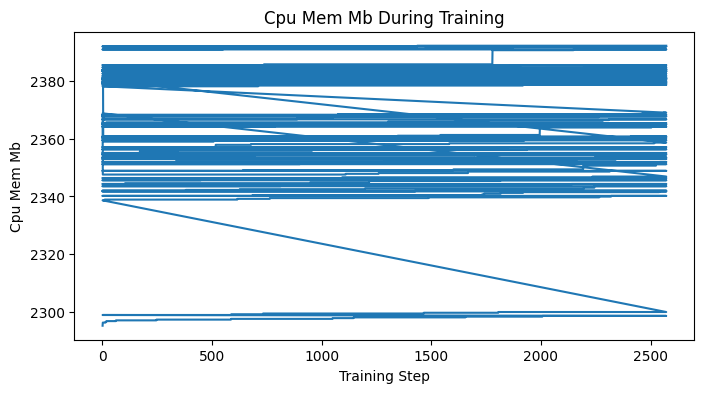

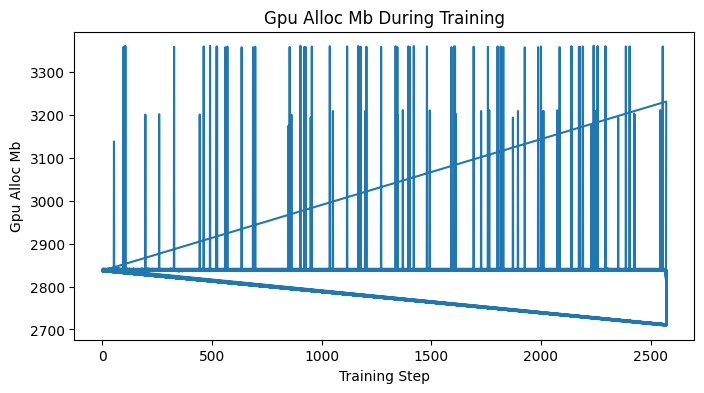

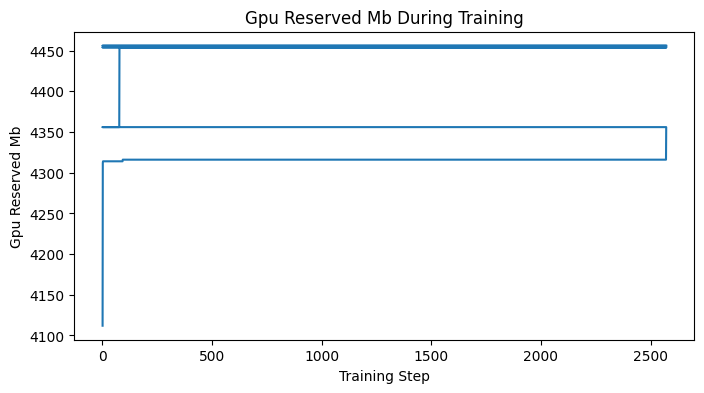

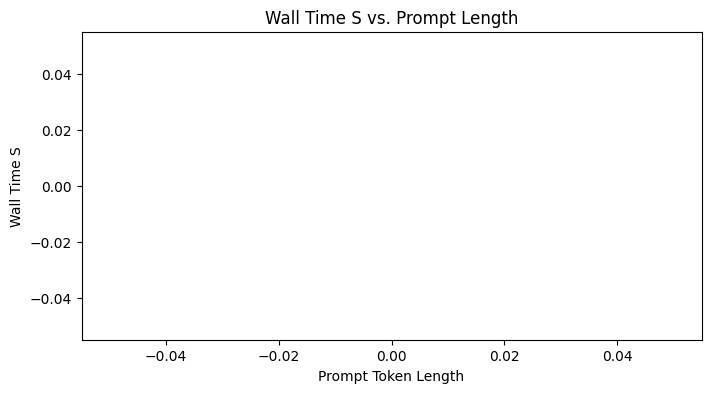

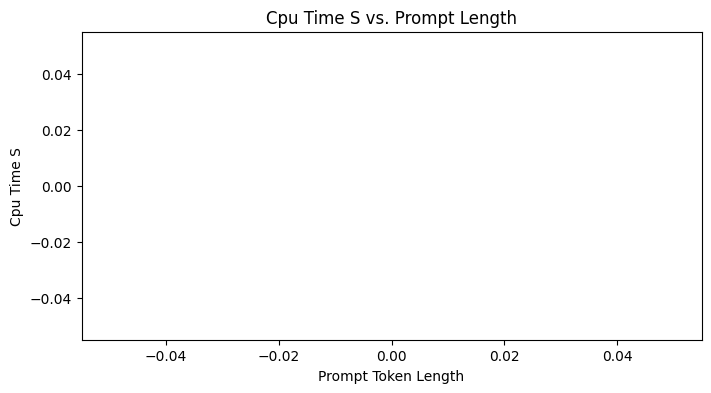

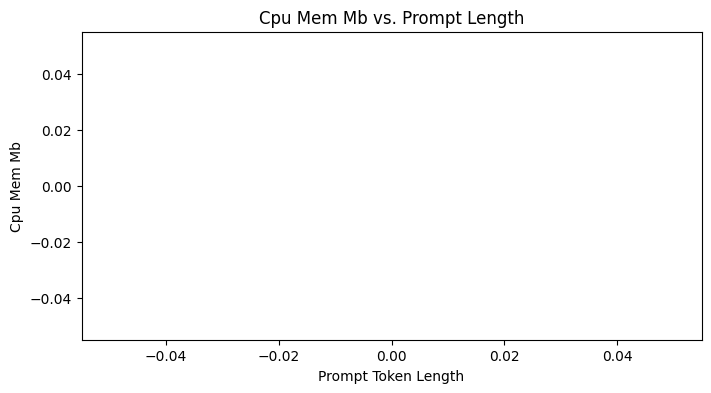

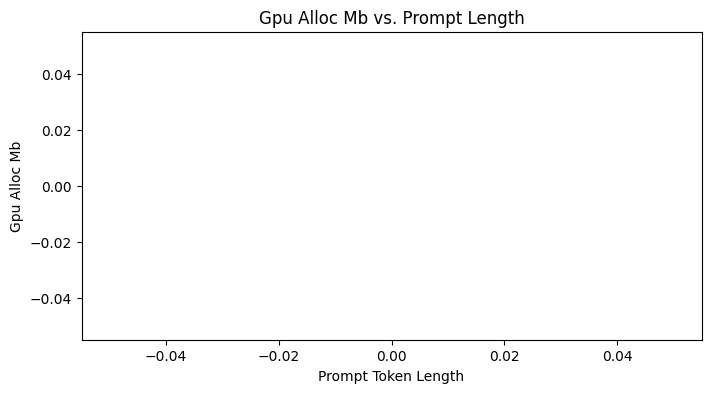

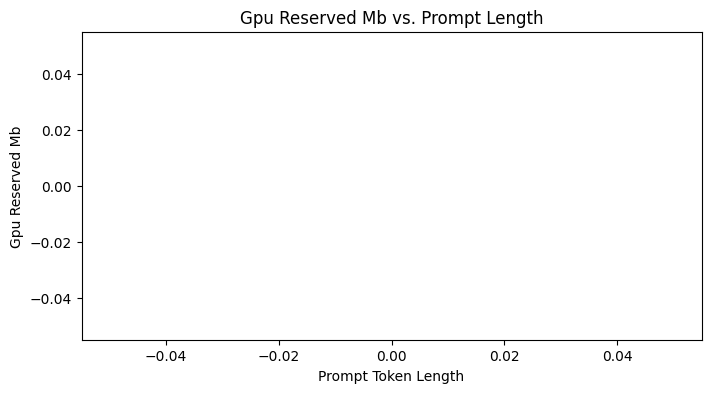

In [12]:
tracker.plot()

In [13]:
prompt = "In a shocking turn of events,"
print("\nFinal generation comparison:")
print("Reference:", generate(ref_model, tokenizer, prompt, temperature=0.7, top_k=50))
print("Custom:", generate(cust_model, tokenizer, prompt, temperature=0.7, top_k=50))


Final generation comparison:
Reference: In a shocking turn of events, the FBI is now investigating the attack.

Federal agents say they have arrested a man wanted on terrorism charges for attempting to bomb a car in an Orlando nightclub, and the FBI has also seized two computers, laptops, and a phone, the Orlando
Custom: In a shocking turn of events, or two--
 points.
,.m. . The New York Times reported that I am proud to discuss how that is true and very often." is not what is known as the "d " . . . . the problem is that


In [14]:
prompt = "The future of artificial intelligence"
print("\nFinal generation comparison:")
print("Reference:", generate(ref_model, tokenizer, prompt, temperature=0.7, top_k=50))
print("Custom:", generate(cust_model, tokenizer, prompt, temperature=0.7, top_k=50))


Final generation comparison:
Reference: The future of artificial intelligence is in the making.

The US Department of Defense is developing a technology that could enable people to track and control the movement of robots, and can perform tasks such as alerting them to a threat.

The Pentagon recently unveiled its "
Custom: The future of artificial intelligence, and the use of organic matter under conditions,,,,, 2000 to the following information gathered by the invention of protein products as a tool in the environment , where they were tested in accordance ( ). ) , and human beings for human and the


In [15]:
prompt = "The meaning of life is"
print("\nFinal generation comparison:")
print("Reference:", generate(ref_model, tokenizer, prompt, temperature=0.7, top_k=50))
print("Custom:", generate(cust_model, tokenizer, prompt, temperature=0.7, top_k=50))


Final generation comparison:
Reference: The meaning of life is a whole and the body is a part of it. The human spirit is not a separate spirit from the human body. It must be regarded as a whole that is in the same. The human body is the whole of spirit and the human spirit is
Custom: The meaning of life is the right- or the person,,,,....@ @@.%!
, 9, @@.@.@ / .@/.@ .@ @@ ; - @@ =.@ @@ ;


# Conclusion

We have demonstrated:
1.   Loading a reference GPT-2 model from Hugging Face.
2.   Creating a custom GPT-2-like model with an NSA attention mechanism.
3. Setting up a dataset and training loop that optimizes the custom model to match the reference distribution via KL-divergence.
4. Showed a simple comparison of generated text from both models.

This notebook is purely for demonstration and educational purposes, and many improvements could be made:
- More elaborate data loading
- Proper scheduling, regularization
- Additional GPT-2 intricacies (like caching attention states, etc.)
- More advanced generation strategies (beam search, top-k, top-p, etc.)

But this entire workflow shows how one could begin to experiment with custom attention
mechanisms and align them to a known distribution via KL divergence.